In [37]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_recall_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import mlflow
import mlflow.sklearn

import warnings
warnings.filterwarnings('ignore')

In [38]:
data = pd.read_csv(r"D:\Amnil Internship code\Credit_card Fraud Detection\Credit_card_transactions.csv\credit_card_transactions.csv")
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0


**trans_date_trans_time**: Timestamp of the transaction.  
**cc_num**: Credit card number (hashed or anonymized).  
**merchant**: Merchant or store where the transaction occurred.  
**categor**: Type of transaction (e.g., grocery, entertainment).  
**amt**: Amount of the transaction.  
**first**: First name of the cardholder.  
**last**: Last name of the cardholder.  
**gender**: Gender of the cardholder.  
**street**: Street address of the cardholder.  
**city**: City of the cardholder.  
**state**: State of the cardholder.  
**zip**: Zip code of the cardholder.  
**lat**: Latitude of the cardholder's location.  
**long**: Longitude of the cardholder's location.
**city_pop**: Population of the city where the transcation occured.  
**job**: Occupation of the cardholder.  
**dob**: Date of birth of the cardholder.  
**trans_num**: Unique transaction identifier.  
**unix_time**: Unix timestamp of the transaction.    
**merch_lat**: Latitude of the merchant's location.  
**merch_long**: Longitude of the merchant's location.  
**is_fraud**: Indicator of whether the transaction is fraudulent.  
**merch_zipcode**: Zip code of the merchant's location.  



In [39]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 24 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [40]:
print(data.columns)

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode'],
      dtype='object')


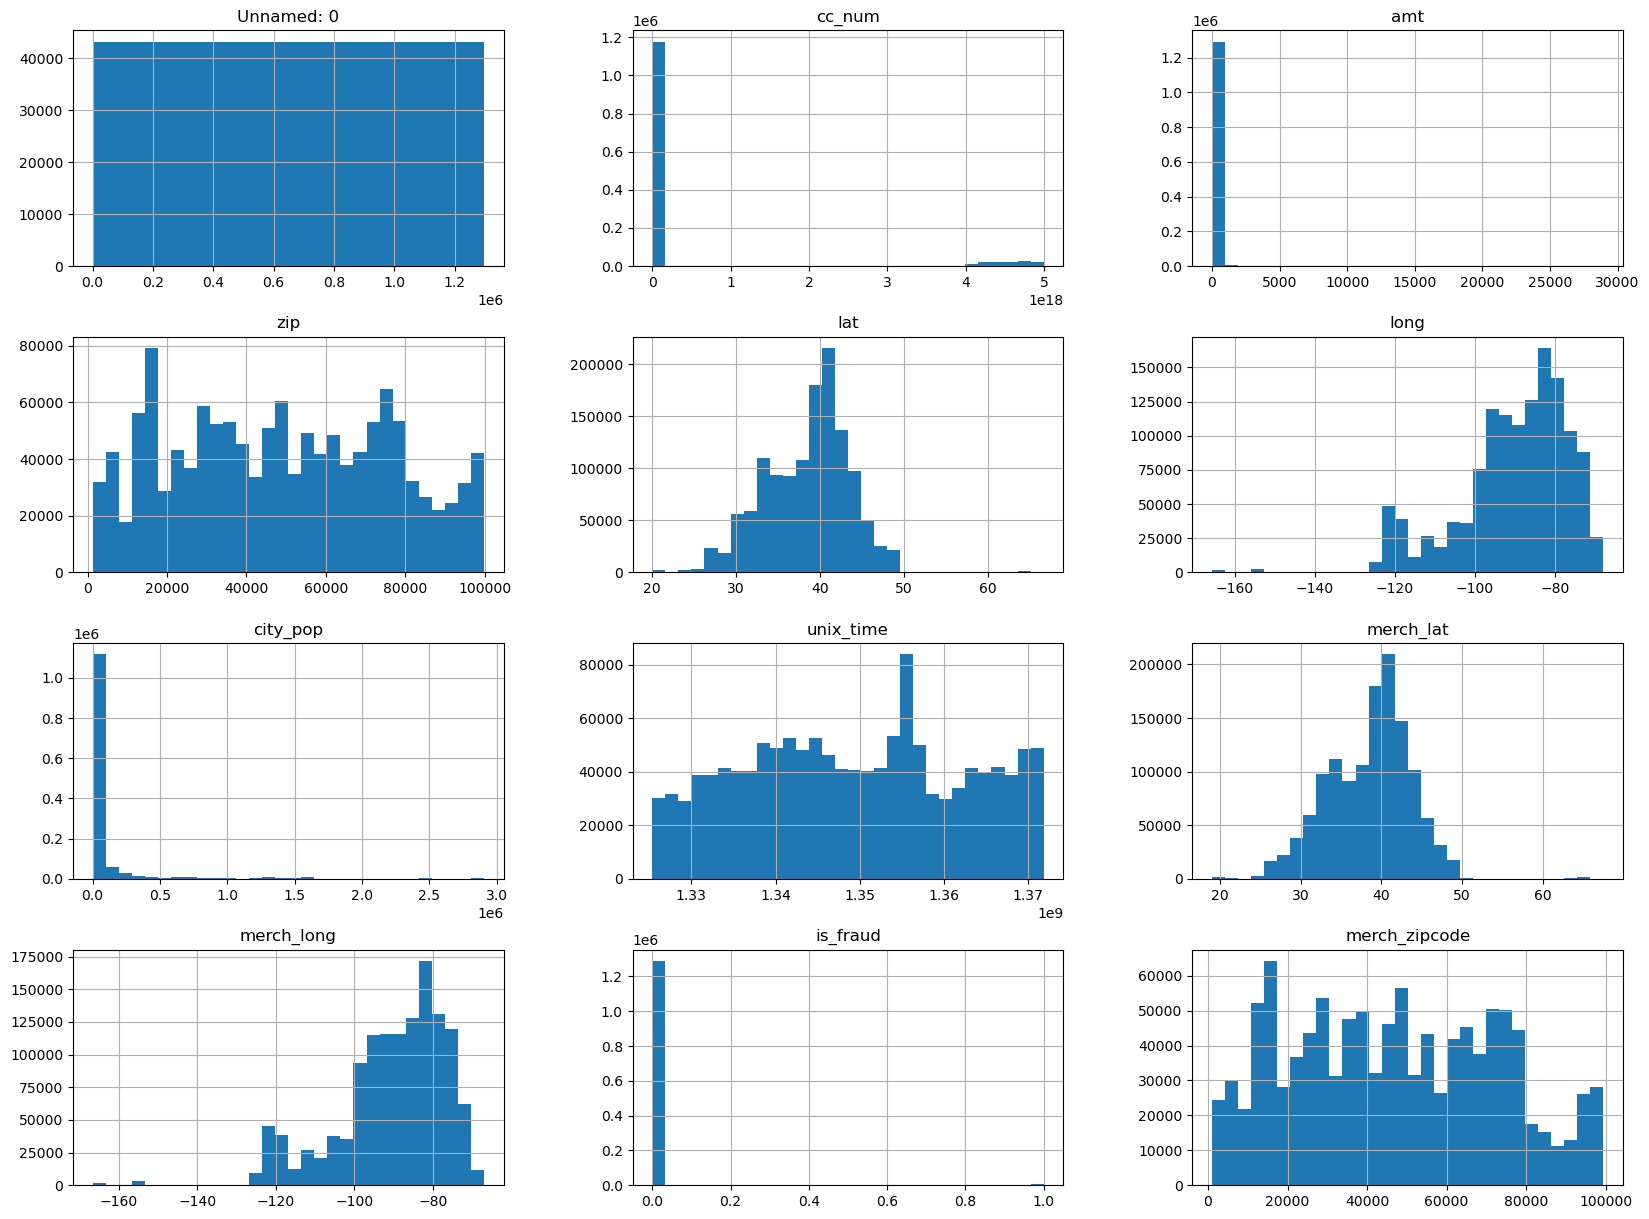

In [41]:
#plot histogram of all features
data.hist(bins=30, figsize=(20, 15))
plt.show()

In [42]:
print(data.isnull().sum())

Unnamed: 0                    0
trans_date_trans_time         0
cc_num                        0
merchant                      0
category                      0
amt                           0
first                         0
last                          0
gender                        0
street                        0
city                          0
state                         0
zip                           0
lat                           0
long                          0
city_pop                      0
job                           0
dob                           0
trans_num                     0
unix_time                     0
merch_lat                     0
merch_long                    0
is_fraud                      0
merch_zipcode            195973
dtype: int64


In [43]:
print(data['is_fraud'].value_counts())

is_fraud
0    1289169
1       7506
Name: count, dtype: int64


In [44]:
print(data['is_fraud'].value_counts(normalize=True) * 100)

is_fraud
0    99.421135
1     0.578865
Name: proportion, dtype: float64


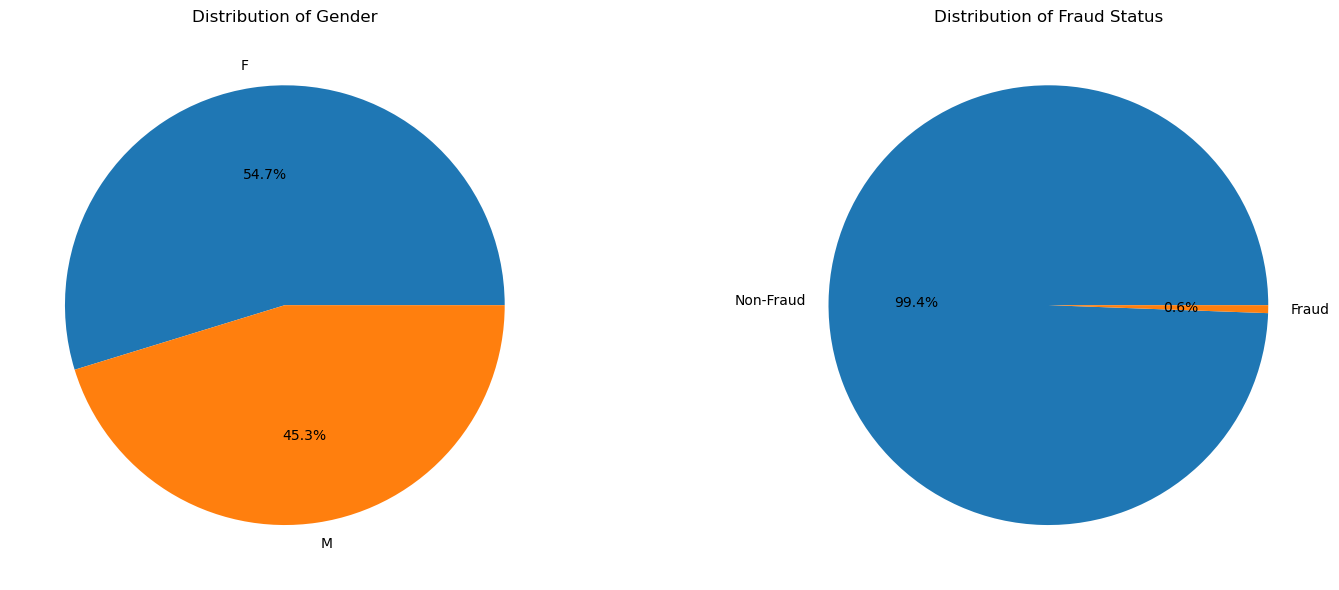

In [45]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot pie chart for gender
gender_counts = data['gender'].value_counts()
axs[0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
axs[0].set_title('Distribution of Gender')

# Plot pie chart for is_fraud
fraud_counts = data['is_fraud'].value_counts()
axs[1].pie(fraud_counts.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%')
axs[1].set_title('Distribution of Fraud Status')

# Layout so plots do not overlap
plt.tight_layout()

plt.show()

The dataset is highly imbalanced with very few fraud cases compared to non-fraud cases(7506 frauds in 1289169 samples). This imbalance can lead to biased model performance, where the model may perform well on the majority class (non-fraud) but poorly on the minority class (fraud). To address this, techniques such as oversampling the minority class, undersampling the majority class, or using specialized algorithms designed for imbalanced datasets can be employed.

In [46]:
# Separate fraud (1) and non-fraud (0)
fraud = data[data['is_fraud'] == 1]
non_fraud = data[data['is_fraud'] == 0]

# Take all fraud cases
fraud_data = fraud  

# Randomly sample 100k from non-fraud
non_fraud_data = non_fraud.sample(n=100000, random_state=42)

# Combine them
data = pd.concat([fraud_data, non_fraud_data])

# Shuffle the dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


In [47]:
print(data.shape)

(107506, 24)


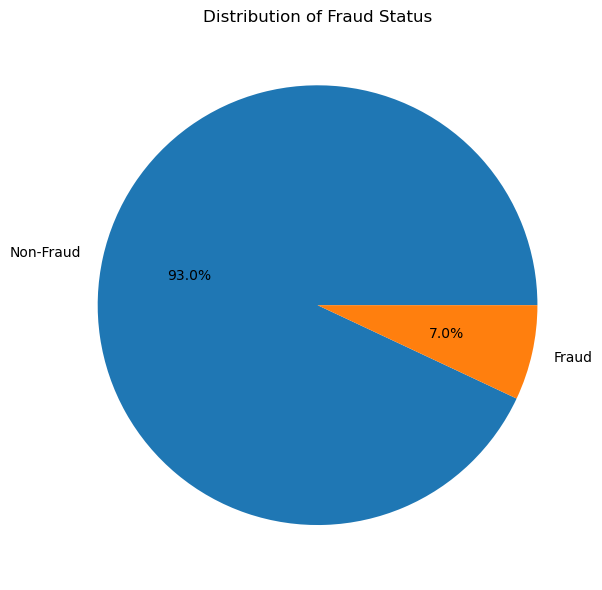

In [48]:
#create a piechart to show fraud and non fraud cases
# Create a figure with two subplots
fig, axs = plt.subplots(figsize=(16, 6))    
# Plot pie chart for is_fraud
fraud_counts = data['is_fraud'].value_counts()
axs.pie(fraud_counts.values, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%')
axs.set_title('Distribution of Fraud Status')
# Layout so plots do not overlap
plt.tight_layout()
plt.show()

In [49]:
from datetime import datetime

# Transform trans_date_trans_time to extract time features
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

# Extract time-based features
data['hour'] = data['trans_date_trans_time'].dt.hour
data['day_of_week'] = data['trans_date_trans_time'].dt.dayofweek  # 0=Monday, 6=Sunday
data['month'] = data['trans_date_trans_time'].dt.month

In [50]:
print(data['month'].value_counts())
print(data['day_of_week'].value_counts())
print(data['hour'].value_counts())

month
5     12332
3     11985
6     11897
12    11638
4     11012
1      8623
2      8272
8      7103
7      7086
11     5937
9      5883
10     5738
Name: count, dtype: int64
day_of_week
0    20958
6    20476
5    16843
1    13261
4    12874
3    12186
2    10908
Name: count, dtype: int64
hour
23    6959
22    6946
17    5212
12    5208
21    5204
16    5192
13    5173
19    5172
18    5160
15    5146
20    5095
14    5038
1     3923
2     3882
3     3858
0     3850
8     3373
7     3365
9     3359
5     3326
10    3283
4     3271
11    3263
6     3248
Name: count, dtype: int64


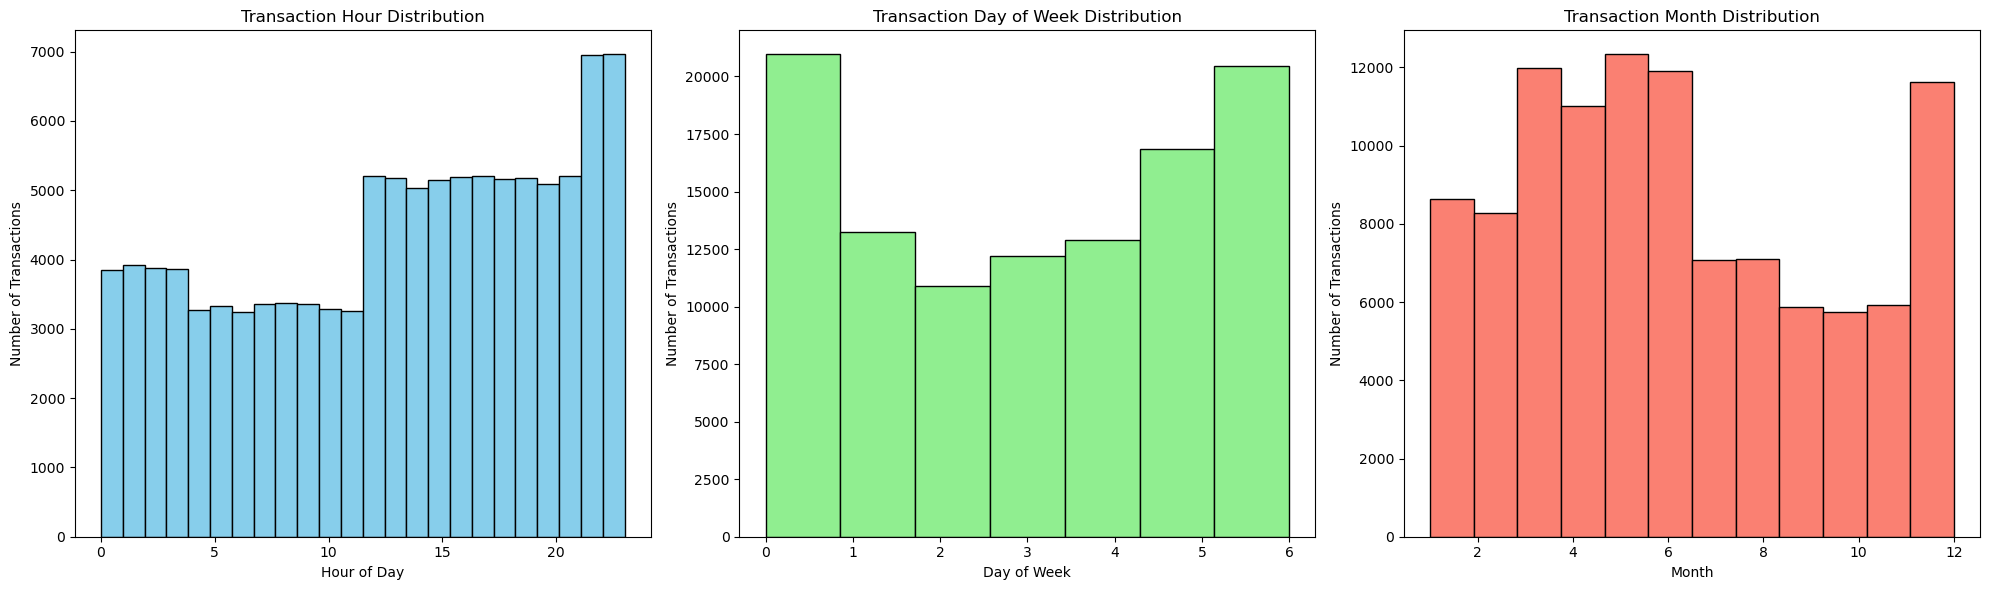

In [51]:
#plot histogram of time features
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].hist(data['hour'], bins=24, color='skyblue', edgecolor='black')
axs[0].set_title('Transaction Hour Distribution')
axs[0].set_xlabel('Hour of Day')
axs[0].set_ylabel('Number of Transactions')
axs[1].hist(data['day_of_week'], bins=7, color='lightgreen', edgecolor='black')
axs[1].set_title('Transaction Day of Week Distribution')
axs[1].set_xlabel('Day of Week')
axs[1].set_ylabel('Number of Transactions')
axs[2].hist(data['month'], bins=12, color='salmon', edgecolor='black')
axs[2].set_title('Transaction Month Distribution')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Number of Transactions')
plt.tight_layout()
plt.show()

In [52]:
#Transform dob to age
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = data['trans_date_trans_time'].dt.year - data['dob'].dt.year

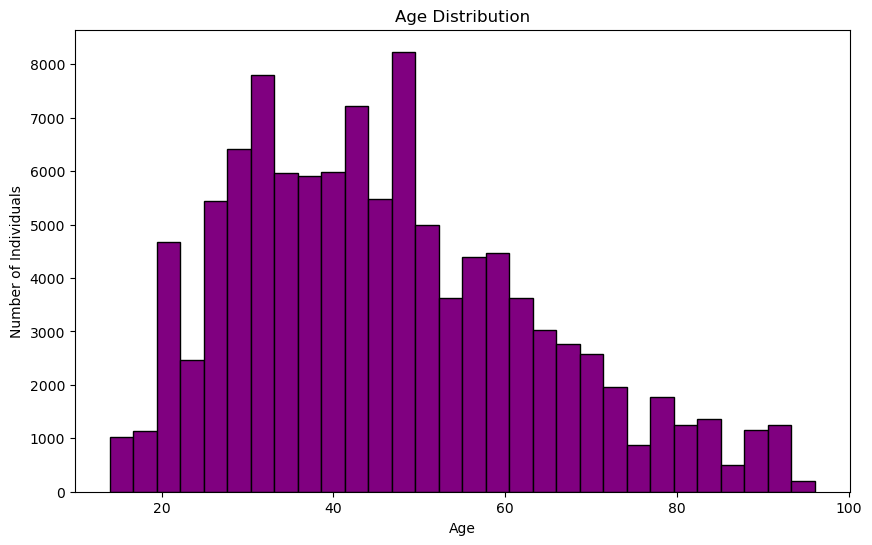

In [53]:
#plot histogram of age
plt.figure(figsize=(10, 6))
plt.hist(data['age'], bins=30, color='purple', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Individuals')
plt.show()

In [54]:
# Haversine formula to calculate distance in kilometers between customer and merchant
R = 6371  # Earth radius in kilometers
lat1 = np.radians(data['lat'])
lon1 = np.radians(data['long'])
lat2 = np.radians(data['merch_lat'])
lon2 = np.radians(data['merch_long'])

dlat = lat2 - lat1
dlon = lon2 - lon1

a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arcsin(np.sqrt(a))
data['dist_km'] = R * c


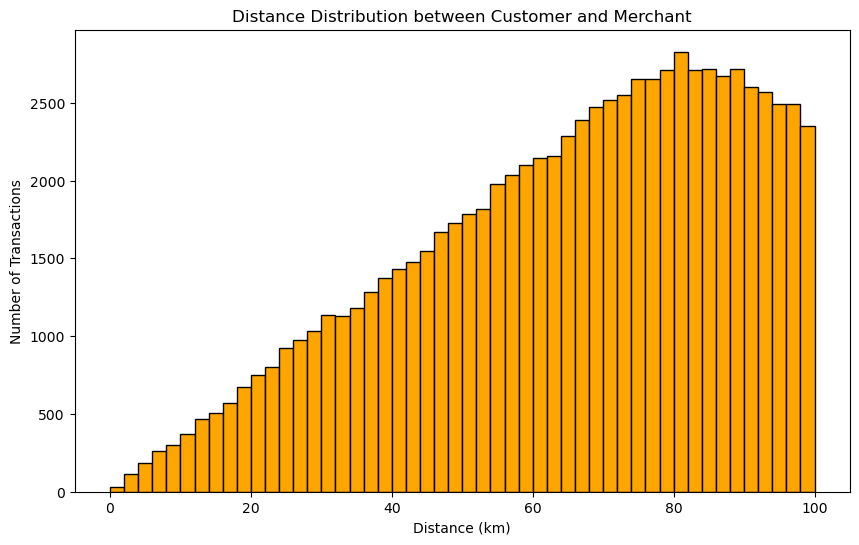

In [55]:
#plot graph to show distance distribution
plt.figure(figsize=(10, 6))
plt.hist(data['dist_km'], bins=50, color='orange', edgecolor='black', range=(0, 100))
plt.title('Distance Distribution between Customer and Merchant')
plt.xlabel('Distance (km)')
plt.ylabel('Number of Transactions')
plt.show()

In [56]:
#Drop unnecessary columns
drop_cols = ['Unnamed: 0','cc_num','first','last','street','trans_num','lat','long','merch_lat','merch_long','unix_time','trans_date_trans_time','dob'
             ,'merch_zipcode','state','city']
data = data.drop(columns=drop_cols, axis=1)
data.head()

,merchant,category,amt,gender,zip,city_pop,job,is_fraud,hour,day_of_week,month,age,dist_km
0,"fraud_Stehr, Jewess and Schimmel",misc_net,110.33,M,59014,1446,Chartered loss adjuster,0,5,0,5,41,47.090093
1,fraud_Cormier LLC,shopping_net,84.46,M,44804,1202,Curator,0,5,3,8,86,91.576857
2,fraud_Upton PLC,entertainment,81.11,M,89512,276896,Immunologist,0,14,0,9,22,63.365631
3,fraud_Towne LLC,misc_pos,3.99,M,87533,18408,Historic buildings inspector/conservation officer,0,19,3,9,47,84.457344
4,fraud_Crona and Sons,kids_pets,22.24,M,51453,695,Administrator,0,17,5,4,66,102.482612


These dropped columns are not necessary for the analysis and could potentially introduce noise or bias into the model. For example, 'cc_num' is sensitive information that should not be used in fraud detection models. Other columns like 'first', 'last', 'street', also do not contribute to the predictive power of the model and can be safely removed to streamline the dataset.insted of street we can use 'city','state','zip' for location based analysis.

In [57]:
print(data.columns)

Index(['merchant', 'category', 'amt', 'gender', 'zip', 'city_pop', 'job',
       'is_fraud', 'hour', 'day_of_week', 'month', 'age', 'dist_km'],
      dtype='object')


In [58]:
print(data.shape)

(107506, 13)


In [59]:
#Split the data into features and target variable
X = data.drop(columns=['is_fraud'])
y = data['is_fraud']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [60]:
# Check data types and identify categorical columns
print("Data types:")
print(data.dtypes)

print("\nCategorical columns (object type):")
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
if 'is_fraud' in categorical_cols:
    categorical_cols.remove('is_fraud')  # Remove target variable
print(categorical_cols)

print("\nUnique values in each categorical column:")
for col in categorical_cols:
    print(f"{col}: {data[col].nunique()} unique values")

Data types:
merchant        object
category        object
amt            float64
gender          object
zip              int64
city_pop         int64
job             object
is_fraud         int64
hour             int32
day_of_week      int32
month            int32
age              int32
dist_km        float64
dtype: object

Categorical columns (object type):
['merchant', 'category', 'gender', 'job']

Unique values in each categorical column:
merchant: 693 unique values
category: 14 unique values
gender: 2 unique values
job: 494 unique values


In [61]:
# Categorize columns by number of unique values
low_cardinality = []    # <= 10 unique values (good for one-hot encoding)
medium_cardinality = [] # 11-50 unique values (can use one-hot or target encoding)
high_cardinality = []   # > 50 unique values (use target encoding or grouping)

categorical_cols = ['merchant', 'category', 'gender', 'job']

for col in categorical_cols:
    unique_count = data[col].nunique()
    if unique_count <= 10:
        low_cardinality.append(col)
    elif unique_count <= 50:
        medium_cardinality.append(col)
    else:
        high_cardinality.append(col)

print("Categorization for encoding strategy:")
print(f"Low cardinality (≤10): {low_cardinality}")
print(f"Medium cardinality (11-50): {medium_cardinality}")  
print(f"High cardinality (>50): {high_cardinality}")

Categorization for encoding strategy:
Low cardinality (≤10): ['gender']
Medium cardinality (11-50): ['category']
High cardinality (>50): ['merchant', 'job']


In [62]:
print(data['gender'].value_counts()) 

gender
F    58332
M    49174
Name: count, dtype: int64


In [63]:
# #label encoding for low cardinality categorical variables
# from sklearn.preprocessing import LabelEncoder
# for col in low_cardinality:
#     le = LabelEncoder()  # New encoder for each column
#     data[col] = le.fit_transform(data[col])
# print(data.head())

In [64]:
# #Label Encoding for medium cardinality categorical variables (Category)
# from sklearn.preprocessing import LabelEncoder

# for col in medium_cardinality:
#     le = LabelEncoder()  # New encoder for each column
#     data[col] = le.fit_transform(data[col])

# print(data.head())

In [65]:
#Target Encoding for high cardinality categorical variables ('merchant', 'job')





In [66]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import TargetEncoder

# 1. One-Hot Encoding for low cardinality (fit on train only)
if low_cardinality:
    ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    ohe.fit(X_train[low_cardinality])
    
    # Transform both sets
    train_ohe = ohe.transform(X_train[low_cardinality])
    test_ohe = ohe.transform(X_test[low_cardinality])
    
    # Convert to DataFrame
    ohe_columns = ohe.get_feature_names_out(low_cardinality)
    train_ohe_df = pd.DataFrame(train_ohe, columns=ohe_columns, index=X_train.index)
    test_ohe_df = pd.DataFrame(test_ohe, columns=ohe_columns, index=X_test.index)
    
    # Replace original columns
    X_train = X_train.drop(columns=low_cardinality).join(train_ohe_df)
    X_test = X_test.drop(columns=low_cardinality).join(test_ohe_df)

# 2. Target Encoding for medium cardinality (fit on train only)
if medium_cardinality:
    te_medium = TargetEncoder(smooth='auto')  # No 'cols' parameter!
    # Fit and transform
    X_train[medium_cardinality] = te_medium.fit_transform(X_train[medium_cardinality], y_train)
    X_test[medium_cardinality] = te_medium.transform(X_test[medium_cardinality])

# 3. Target Encoding for high cardinality (merchant, job)
if high_cardinality:
    te_high = TargetEncoder(smooth='auto')  # No 'cols' parameter!
    # Fit and transform
    X_train[high_cardinality] = te_high.fit_transform(X_train[high_cardinality], y_train)
    X_test[high_cardinality] = te_high.transform(X_test[high_cardinality])

print("Encoding complete!")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("\nX_train head:")
print(X_train.head())

Encoding complete!
X_train shape: (86004, 12)
X_test shape: (21502, 12)

X_train head:
        merchant  category     amt    zip  city_pop       job  hour  \
92813   0.079774  0.038649   62.02  76626      1563  0.030348     2   
71375   0.078180  0.090205    9.04  92637     45303  0.205597     1   
70524   0.028019  0.021001  122.60  38060      9496  0.000000    14   
30222   0.011747  0.027968   94.99  89319       450  0.047802    15   
100102  0.212697  0.159753  133.48  79759        23  0.038374     8   

        day_of_week  month  age     dist_km  gender_M  
92813             3      7   41   60.277168       0.0  
71375             6      6   50  123.168942       0.0  
70524             2      9   26   99.918135       1.0  
30222             5      5   74   44.523260       1.0  
100102            2      8   50  108.092293       0.0  


In [67]:
print(data.columns)

Index(['merchant', 'category', 'amt', 'gender', 'zip', 'city_pop', 'job',
       'is_fraud', 'hour', 'day_of_week', 'month', 'age', 'dist_km'],
      dtype='object')


In [75]:
#Scaling numerial features
numerical_cols = ['amt','zip','city_pop', 'age', 'dist_km', 'hour', 'day_of_week', 'month']

from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols)
    ], remainder='passthrough'
)


In [76]:
rf_pipe= ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42,n_jobs=1))
])

GridSearchCv for hyperparameter tuning

In [78]:
#Random Forest Classifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

rf_param_grid = {
    'clf__n_estimators': [50,100,200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}
cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_search = GridSearchCV(rf_pipe, rf_param_grid,cv=cv, scoring='f1',
                         n_jobs=-1,verbose=2, refit=True)

rf_search.fit(X_train, y_train)
print("RF best params:", rf_search.best_params_)


Fitting 5 folds for each of 18 candidates, totalling 90 fits
RF best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [83]:
#XGBoost Classifier

xgb_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_param_grid = {
    'clf__n_estimators': [100,200, 300],
    'clf__max_depth': [3, 6],
    'clf__learning_rate': [0.1, 0.01]
}

xgb_search = GridSearchCV(xgb_pipe, xgb_param_grid, cv=5, scoring='f1',
                          n_jobs=-1, verbose=2)
xgb_search.fit(X_train, y_train)
print("XGB best params:", xgb_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
XGB best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 300}


In [84]:
#LightGBM Classifier

lgbm_pipe = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LGBMClassifier(random_state=42))
])

lgbm_param_grid = {
    'clf__n_estimators': [100, 300],
    'clf__num_leaves': [31, 63],
    'clf__learning_rate': [0.1, 0.01]
}

lgbm_search = GridSearchCV(lgbm_pipe, lgbm_param_grid, cv=5, scoring='f1',
                           n_jobs=-1, verbose=2)
lgbm_search.fit(X_train, y_train)
print("LGBM best params:", lgbm_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Number of positive: 79999, number of negative: 79999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3059
[LightGBM] [Info] Number of data points in the train set: 159998, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM best params: {'clf__learning_rate': 0.1, 'clf__n_estimators': 300, 'clf__num_leaves': 63}


In [ ]:
#print shape of datasets before and after smote
print("Before SMOTE:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nAfter SMOTE:")
X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)


Before SMOTE:
X_train shape: (86004, 12)
y_train shape: (86004,)

After SMOTE:
X_resampled shape: (159998, 12)
y_resampled shape: (159998,)


In [85]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report

In [80]:
best_rf_model = rf_search.best_estimator_

#Evaluate on test set
y_pred = best_rf_model.predict(X_test)
y_prob = best_rf_model.predict_proba(X_test)[:, 1] if hasattr(best_rf_model,"predict_proba")else None


In [81]:
 # Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
if y_prob is not None:
    roc_auc = roc_auc_score(y_test, y_prob)
else:
    roc_auc = None

print(f"Accuracy={accuracy:.4f}, F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")
if roc_auc is not None:
    print(f"ROC AUC={roc_auc:.4f}")

Accuracy=0.9835, F1=0.8829, Precision=0.8766, Recall=0.8894
ROC AUC=0.9923



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     20001
           1       0.79      0.92      0.85      1501

    accuracy                           0.98     21502
   macro avg       0.89      0.95      0.92     21502
weighted avg       0.98      0.98      0.98     21502



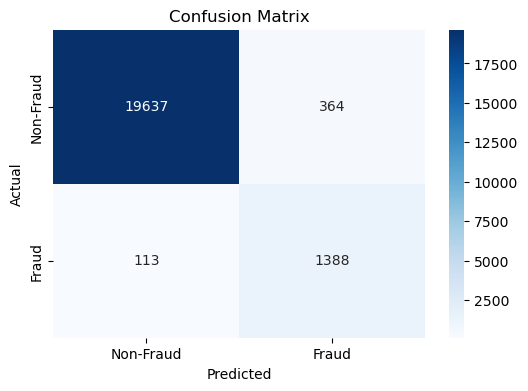

In [90]:
#print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
#EDA and Feature Engineering

#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [91]:
#evluate XGBoost model
best_xgb_model = xgb_search.best_estimator_
#Evaluate on test set
y_pred = best_xgb_model.predict(X_test)

y_prob = best_xgb_model.predict_proba(X_test)[:, 1] if hasattr(best_xgb_model,"predict_proba")else None



In [92]:
#calculate metrics for XGBoost
accuracy = accuracy_score(y_test, y_pred)   
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred) 


if y_prob is not None:  
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"XGBoost - ROC AUC={roc_auc:.4f}")

print(f"XGBoost - Accuracy={accuracy:.4f}, F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")





XGBoost - ROC AUC=0.9916
XGBoost - Accuracy=0.9778, F1=0.8534, Precision=0.7922, Recall=0.9247


In [95]:
#Tracking experiments with MLflow
import joblib
import mlflow
import mlflow.sklearn

best_rf = rf_search.best_estimator_

#Log wiwth MLflow
mlflow.set_experiment("Random_Forest_Credit_Card_Fraud_Detections1")
mlflow.set_tracking_uri("http://127.0.0.1:5000")


with mlflow.start_run():
    
    # log best params
    mlflow.log_params(rf_search.best_params_)
   
    # log metrics
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    if roc_auc is not None:
        mlflow.log_metric("roc_auc", roc_auc)       


2025/10/09 20:29:13 INFO mlflow.tracking.fluent: Experiment with name 'Random_Forest_Credit_Card_Fraud_Detections1' does not exist. Creating a new experiment.


🏃 View run handsome-doe-609 at: http://127.0.0.1:5000/#/experiments/653833301098912107/runs/d0c77cbb310a490b8625f27c2011b83c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/653833301098912107


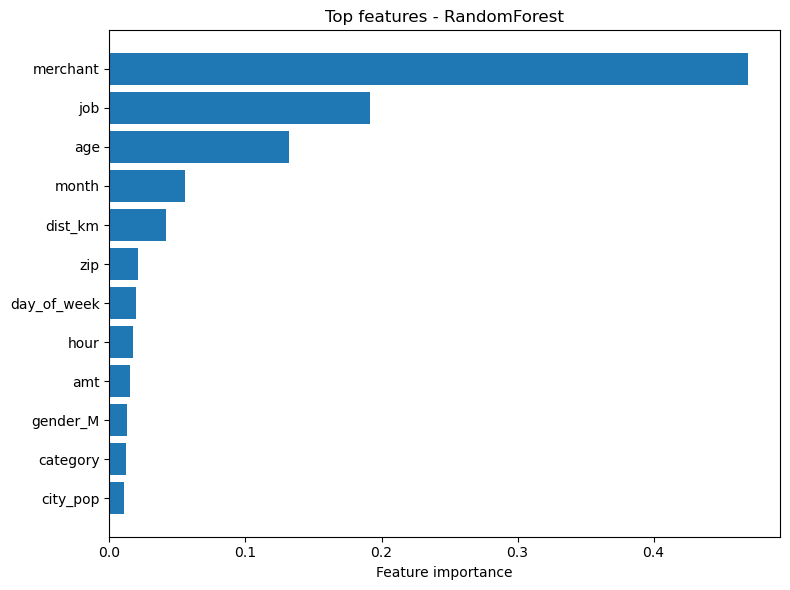

<Figure size 640x480 with 0 Axes>

In [96]:
#Feature importance 
# visualize feature importance for RandomForest

# get the classifier inside the pipeline
clf = rf_search.best_estimator_.named_steps['clf']

# if using pandas DataFrame for X:
feature_names = X_train.columns.tolist()

importances = clf.feature_importances_
# sort
idx = np.argsort(importances)[::-1]
top_n = 20  # change as needed

plt.figure(figsize=(8,6))
plt.barh([feature_names[i] for i in idx[:top_n]][::-1], importances[idx][:top_n][::-1])
plt.xlabel("Feature importance")
plt.title("Top features - RandomForest")
plt.tight_layout()
plt.show()
# optionally save
plt.savefig("rf_feature_importance.png")


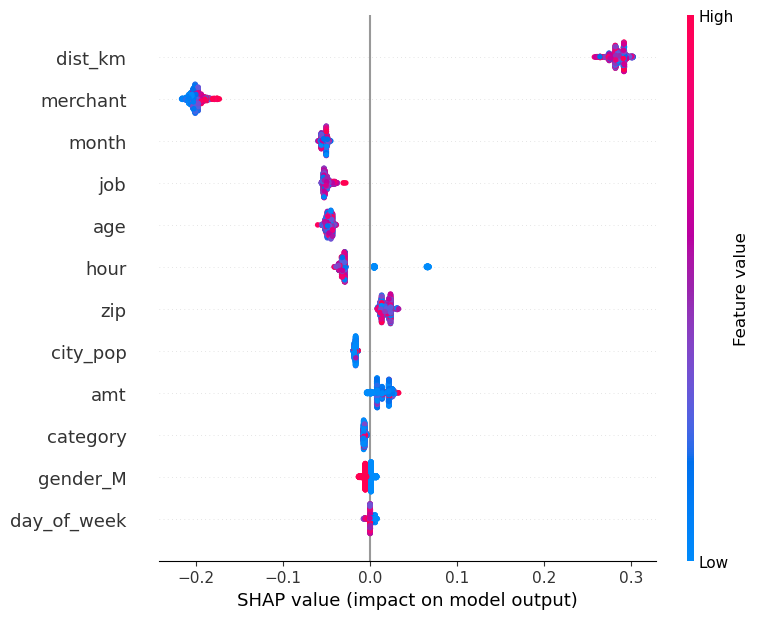

In [97]:
import shap
import matplotlib.pyplot as plt

# Get classifier and SHAP values
clf = rf_search.best_estimator_.named_steps['clf']
explainer = shap.TreeExplainer(clf)

X_sample = X_train.sample(n=min(1000, len(X_train)), random_state=42)
shap_values = explainer.shap_values(X_sample)

# Fix: Select class 1 from the 3D array
shap_values_class1 = shap_values[:, :, 1]

# Summary plot with all features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_sample, max_display=20, show=False)
plt.tight_layout()
plt.savefig("shap_summary_all_features.png", dpi=300, bbox_inches='tight')
plt.show()